# Train Model with GPT architecture

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.GPT import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29


In [5]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 2
seqlen = 127

In [6]:
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
config = GPTConfig(vocab_size=charlen, block_size=128, num_props=24)
model = GPT(config).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=char_to_index['?'])
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 0.84M


In [7]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        output = model(idx=tgt_input, prop=synthesis_condition)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != char_to_index['?'])
        num_words = (tgt_label != char_to_index['?']).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [8]:
def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output = model(idx=tgt_input, prop=synthesis_condition)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != char_to_index['?'])
            num_words = (tgt_label != char_to_index['?']).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [9]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_GPT_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_GPT_model.pth')

100%|██████████| 284/284 [00:08<00:00, 32.36it/s]


epoch: 0, train loss: 1.1040, train acc: 0.6257


100%|██████████| 68/68 [00:00<00:00, 96.84it/s]


epoch: 0 test loss: 0.8042, test acc: 0.7071


100%|██████████| 284/284 [00:08<00:00, 33.36it/s]


epoch: 1, train loss: 0.7796, train acc: 0.7101


100%|██████████| 68/68 [00:00<00:00, 96.78it/s]

epoch: 1 test loss: 0.6854, test acc: 0.7414


In [18]:
def generate_gpt(model, start_sequence, condition_props, max_length, char_to_index, index_to_char, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (GPT): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        char_to_index (dict): A mapping from characters to their corresponding indices.
        index_to_char (dict): A mapping from indices to their corresponding characters.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits = model(generated_sequences, condition_props)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token ('$')
        if all(next_token[i].item() == char_to_index['$'] for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding ('?') and start ('^') tokens
        # check if the generated sequence contains the end token ('$'), if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == char_to_index['$']:
                break
            elif idx.item() != char_to_index['?'] and idx.item() != char_to_index['^']:
                smiles += index_to_char[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [19]:
# test the generate function
# check the first 10 samples
train_zeo = train_zeo[:10].astype(np.float32)
train_syn = train_syn[:10].astype(np.float32)
zeo = torch.tensor(train_zeo, dtype=torch.float32).to(device)
syn = torch.tensor(train_syn, dtype=torch.float32).to(device)
target_smi = train_smiles[:10]
start_sequence = torch.full((10, 1), char_to_index['^'], dtype=torch.long)
start_sequence = start_sequence.to(device)
condition_synthesis = torch.cat([zeo, syn], dim=1)
generated_smiles = generate_gpt(model, start_sequence, condition_synthesis, seqlen, char_to_index, index_to_char, device)
print('target smiles:')
print(target_smi)
print('generated smiles:')
print(generated_smiles)

target smiles:
[['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C']
 ['Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C']
 ['Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C']
 ['c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C']
 ['[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
 ['Cc1n(C)cc[n+]1Cc1ccccc1C[n+]1c(n(cc1)C)C']
 ['Cn1c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(c1C)C']
 ['c1c[n+](Cc2ccccc2C[n+]2c(C)n(cc2)C)c(C)n1C']
 ['n1(cc[n+](c1C)Cc1ccccc1C[n+]1ccn(C)c1C)C']
 ['[n+]1(Cc2c(C[n+]3c(n(cc3)C)C)cccc2)c(C)n(C)cc1']]
generated smiles:
['C(CCCCCCCCCC[N+](C)(C)C)(C)C', 'c1cn(C[n+]2c(ccccc2)C)C1c(n1)C', '[n+]1(ccn(c1C)C)CCCC[n+]1cc(n(C)cc1C)C', 'c1ccc(C[n+]2cc(c2)C)ccc(n1)C', 'c1(C[n+]2c(n(cc2)C)cccc1)C[n+]1cn(c(n(C)c1C)C)C', 'C(CC[n+]1cccnN(C)c1)CC', 'c1cccn([n+]2cn(C)c(C)n2C)ccc(C)cc1', 'Cc1[n+](CCCCc2)cc(n(C)c2)C)c(C)=C1', 'c1cc(cc(C)n(c1)C)[n+]1Cc(n(C)cc1)C', '[n+]1(Cc(n(C)cc1)Cccc1)CCCC[n+]1cn(c(C)C)c1C']


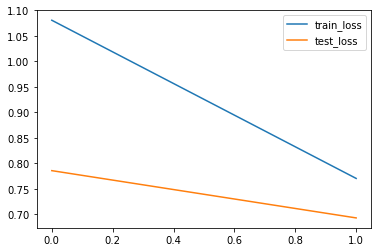

In [ ]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'GPT')